<a href="https://colab.research.google.com/github/yanaa11/media-opinion-analyzer/blob/main/try_doc2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:
import os
import re
import random

import pandas as pd
import numpy as np

import gensim
import nltk
from nltk.corpus import stopwords

import matplotlib.pyplot as plt

In [58]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [59]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
os.listdir("/content/drive/MyDrive/comments")

['JoeBiden_train.csv',
 'The_Donald_train.csv',
 'JoeBiden_test.csv',
 'The_Donald_test.csv']

In [61]:
#comments_dir = "Lecture - Text embeddings (Medvedev)/codes/comments"
comments_dir = "/content/drive/MyDrive/comments"

In [62]:
# TRUMP COMMENTS
trump_comments_file = "./The_Donald_train.csv"
trump_comments_path = os.path.join(comments_dir, trump_comments_file)
trump_df_train = pd.read_csv(trump_comments_path, index_col = 0)

trump_comments_file = "./The_Donald_test.csv"
trump_comments_path = os.path.join(comments_dir, trump_comments_file)
trump_df_test = pd.read_csv(trump_comments_path, index_col = 0)

# BIDEN COMMENTS
biden_comments_file = "./JoeBiden_train.csv"
biden_comments_path = os.path.join(comments_dir, biden_comments_file)
biden_df_train = pd.read_csv(biden_comments_path, index_col = 0)

biden_comments_file = "./JoeBiden_test.csv"
biden_comments_path = os.path.join(comments_dir, biden_comments_file)
biden_df_test = pd.read_csv(biden_comments_path, index_col = 0)

In [110]:
n_entries = 10000

In [128]:
len(trump_df_test)

2822

In [127]:
trump_df_test.head()

,body
11285,57 comments\n\nI can see 25.\n\nAll opinions a...
11286,Not likely. It's an intentional slow roast... ...
11287,"Thank you, Tom!"
11288,Dorian Yates barndoor back
11289,Here are some tunes to listen to while you enj...


In [111]:
s_trump_df_train = trump_df_train[:n_entries]
s_trump_df_train['who'] = 0 # 0 == trump
s_biden_df_train = biden_df_train[:n_entries]
s_biden_df_train['who'] = 1 # 1 == biden
s_all_df = pd.concat([s_trump_df_train, s_biden_df_train])
s_all_df.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,body,who
0,"We love you, Tom! And we love Judicial Watch! ...",0
1,I don’t know what that is.,0
2,"To be honest, it probably is. But more publici...",0
3,"Definitely eRection interference, pun intended...",0
4,Ant update?,0


In [112]:
def tokenize(text, stopwords, max_len = 20):
    return [token for token in gensim.utils.simple_preprocess(text, max_len=max_len) if token not in stopwords]

In [113]:
stops = set(stopwords.words("english"))
def remove_stopwords(text):
    words = [w for w in text.lower().split() if not w in stops]
    return words

def remove_punctuation(text):
    #r_text = re.sub(r"[(),!.?\'\`:;0-9]", "", text)
    r_text = re.sub(r"[^A-Za-z]", " ", text)
    return r_text

In [114]:
s_trump_train = [remove_stopwords(remove_punctuation(text)) for text in s_trump_df_train["body"].to_list()]
s_biden_train = [remove_stopwords(remove_punctuation(text)) for text in s_biden_df_train["body"].to_list()]

In [115]:
labeled_s_trump_train = [gensim.models.doc2vec.TaggedDocument(text, [i]) for i, text in enumerate(s_trump_train)]
offset = len(s_trump_train)
labeled_s_biden_train = [gensim.models.doc2vec.TaggedDocument(text, [i+offset]) for i, text in enumerate(s_biden_train)]

In [117]:
train_corpus = []
train_corpus += labeled_s_trump_train
train_corpus += labeled_s_biden_train

In [118]:
%%time
model = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=2, epochs=20)
model.build_vocab(train_corpus)
model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)

CPU times: user 1min 17s, sys: 11.4 s, total: 1min 28s
Wall time: 1min 2s


In [119]:
trump_sim = []
biden_sim = []
tb_sim = []

for i in range(10000):
  t1 = random.randint(0, n_entries-1)
  t2 = t1
  while t2 == t1:
    t2 = random.randint(0, n_entries-1)

  b1 = random.randint(n_entries, 2*n_entries-1)
  b2 = b1 
  while b2 == b1:
    b2 = random.randint(n_entries, 2*n_entries-1)

  trump_sim.append(model.docvecs.similarity(t1, t2))
  biden_sim.append(model.docvecs.similarity(b1, b2))
  tb_sim.append(model.docvecs.similarity(t1, b2))

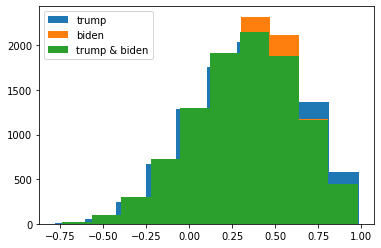

In [120]:
plt.hist(trump_sim, label='trump')
plt.hist(biden_sim, label='biden')
plt.hist(tb_sim, label='trump & biden')
plt.legend()

In [122]:
print('average similarity trump: ', sum(trump_sim)/len(trump_sim))
print('average similarity biden', sum(biden_sim)/len(biden_sim))
print('average similarity biden-trump', sum(tb_sim)/len(tb_sim))

average similarity trump:  0.3463027575001819
average similarity biden 0.34692841714616424
average similarity biden-trump 0.3290115638932446


In [123]:
inf_trump = model.infer_vector(remove_stopwords(remove_punctuation(trump_df_test['body'][13000])))
inf_biden = model.infer_vector(remove_stopwords(remove_punctuation(biden_df_test['body'][13000])))

In [124]:
model.docvecs.most_similar([inf_trump])

[(964, 0.5689812302589417),
 (5850, 0.520695686340332),
 (8834, 0.5188019275665283),
 (1725, 0.5169485807418823),
 (14612, 0.4986858665943146),
 (838, 0.4978404641151428),
 (19739, 0.49657702445983887),
 (19985, 0.46575963497161865),
 (14413, 0.46432650089263916),
 (9916, 0.4635835587978363)]

In [125]:
model.docvecs.most_similar([inf_biden])

[(18622, 0.7476060390472412),
 (10336, 0.7288316488265991),
 (1066, 0.7237259149551392),
 (13236, 0.7144524455070496),
 (8894, 0.7144016027450562),
 (11626, 0.6931387186050415),
 (5069, 0.6897291541099548),
 (14911, 0.6892868280410767),
 (12258, 0.6863023638725281),
 (5183, 0.6853554248809814)]